# quickstart Example with Synthetic Bandit Data
https://github.com/st-tech/zr-obp/blob/master/examples/quickstart/synthetic.ipynb

In [2]:
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.linear_model import LogisticRegression as LR

import obp
from obp.dataset import (
    SyntheticBanditDataset,
    logistic_reward_function,
    linear_reward_function
)
from obp.policy import IPWLearner, Random
from obp.ope import (
    OffPolicyEvaluation,
    RegressionModel,
    InverseProbabilityWeighting as IPS,
    DirectMethod as DM,
    DoublyRobust as DR
)

/root/.cache/pypoetry/virtualenvs/mldesign-9TtSrW0h-py3.8/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:matplotlib.font_manager:generated new fontManager


## (1) Generating Synthetic Data

In [5]:
dataset =  SyntheticBanditDataset(
    n_actions=10,
    dim_context=5,
    reward_type="binary",
    reward_function=logistic_reward_function,
    random_state=12345
)

In [6]:
n_rounds_train, n_rounds_test = 100000, 100000
bandit_feedback_train = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds_train)
bandit_feedback_test = dataset.obtain_batch_bandit_feedback(n_rounds=n_rounds_test)


In [18]:
bandit_feedback_train

{'n_rounds': 100000,
 'n_actions': 10,
 'context': array([[-0.20470766,  0.47894334, -0.51943872, -0.5557303 ,  1.96578057],
        [ 1.39340583,  0.09290788,  0.28174615,  0.76902257,  1.24643474],
        [ 1.00718936, -1.29622111,  0.27499163,  0.22891288,  1.35291684],
        ...,
        [ 1.36946256,  0.58727761, -0.69296769, -0.27519988, -2.10289159],
        [-0.27428715,  0.52635353,  1.02572168, -0.18486381,  0.72464834],
        [-1.25579833, -1.42455203, -0.26361242,  0.27928604,  1.21015571]]),
 'action_context': array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]),
 'action': array([8, 4, 0, ..., 8, 9, 7]),
 'position': None,
 'r

## (2) Off-Policy Learning

In [20]:
# バンディット　ロジスティクス回帰
ipw_lr = IPWLearner(
    n_actions=dataset.n_actions,
    base_classifier=LR(C=100, random_state=12345)
)

ipw_lr.fit(
    context=bandit_feedback_train["context"],
    action=bandit_feedback_train["action"],
    reward=bandit_feedback_train["reward"],
    pscore=bandit_feedback_train["pscore"]
)

action_dist_ipw_lr = ipw_lr.predict(context=bandit_feedback_test["context"])


In [21]:
# バンディット　ランダムフォレスト
ipw_rf = IPWLearner(
    n_actions=dataset.n_actions,
    base_classifier=RF(n_estimators=30, min_samples_leaf=10, random_state=12345)
)

ipw_rf.fit(
    context=bandit_feedback_train["context"],
    action=bandit_feedback_train["action"],
    reward=bandit_feedback_train["reward"],
    pscore=bandit_feedback_train["pscore"]
)

action_dist_ipw_rf = ipw_rf.predict(context=bandit_feedback_test["context"])

In [22]:
# ベースラインとしてのランダム　policy
random = Random(n_actions=dataset.n_actions)

action_dist_random = random.compute_batch_action_dist(
    n_rounds=bandit_feedback_test["n_rounds"])

In [27]:
action_dist_ipw_lr[:,:,0]

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

## (3) Off-Policy Evaluation 

### (3-1) Obtaining a reward estimators

$$
\hat{q}(x,a) \approx \mathbb{E} [r \mid x,a]
$$

In [29]:
regression_model = RegressionModel(
    n_actions=dataset.n_actions,
    action_context=dataset.action_context,
    base_model=LR(random_state=12345)
)

In [32]:
estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=bandit_feedback_test["context"],
    action=bandit_feedback_test["action"],
    reward=bandit_feedback_test["reward"],
    n_folds=3,
    random_state=12345
)

### (3-2) Off-Policy Evaluation
$$V(\pi_e) \approx \hat{V} (\pi_e; \mathcal{D}_b, \theta)$$using DM, IPW and DR

In [33]:
ope = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback_test,
    ope_estimators=[IPS(),DM(),DR()]
)

         mean  95.0% CI (lower)  95.0% CI (upper)
ipw  0.784774          0.769550          0.801240
dm   0.641326          0.640181          0.642832
dr   0.779408          0.771134          0.786704 



/root/.cache/pypoetry/virtualenvs/mldesign-9TtSrW0h-py3.8/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


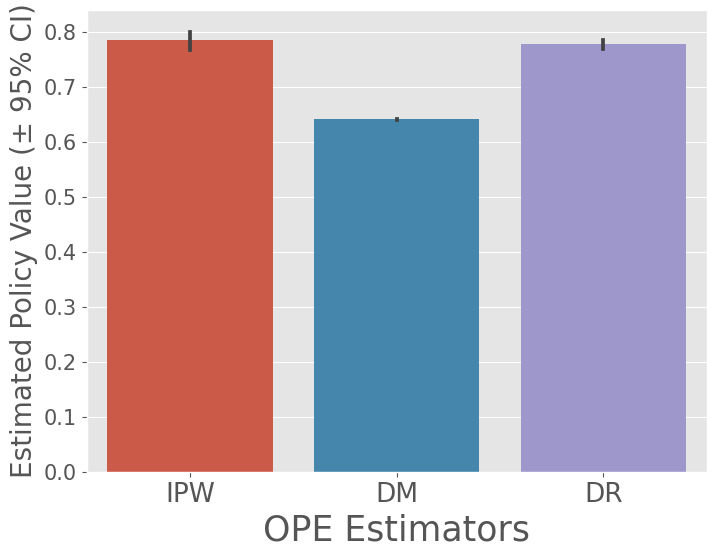

In [34]:
# バンディット　ロジスティクス回帰の性能
estimated_policy_value_a, estimated_interval_a = ope.summarize_off_policy_estimates(
    action_dist=action_dist_ipw_lr,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model
)
print(estimated_interval_a,"\n")

ope.visualize_off_policy_estimates(
    action_dist=action_dist_ipw_lr,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=1000,
    random_state=12345
)


         mean  95.0% CI (lower)  95.0% CI (upper)
ipw  0.712198          0.697075          0.729522
dm   0.626951          0.625703          0.628180
dr   0.716898          0.707932          0.724247 



/root/.cache/pypoetry/virtualenvs/mldesign-9TtSrW0h-py3.8/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


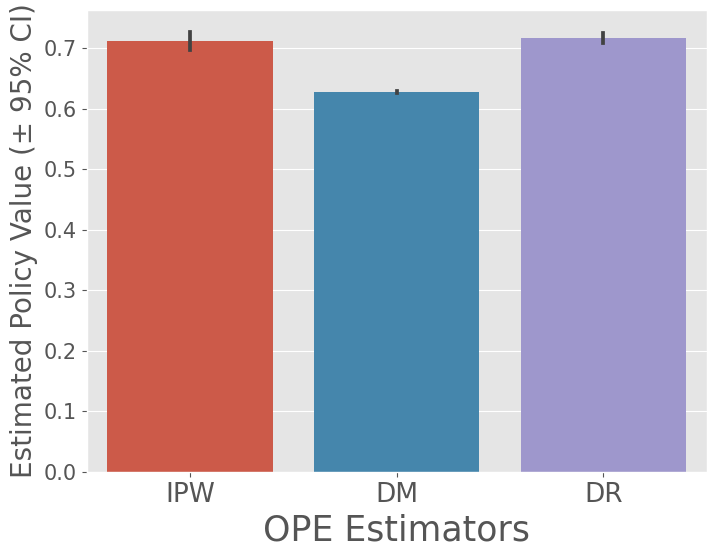

In [35]:
# バンディット　ランダムフォレストの性能
estimated_policy_value_b, estimated_interval_b = ope.summarize_off_policy_estimates(
    action_dist=action_dist_ipw_rf,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model
)
print(estimated_interval_b,"\n")

ope.visualize_off_policy_estimates(
    action_dist=action_dist_ipw_rf,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=1000,
    random_state=12345
)

         mean  95.0% CI (lower)  95.0% CI (upper)
ipw  0.604982          0.602338          0.607724
dm   0.605340          0.604038          0.606652
dr   0.605257          0.602648          0.608336 



/root/.cache/pypoetry/virtualenvs/mldesign-9TtSrW0h-py3.8/lib/python3.8/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


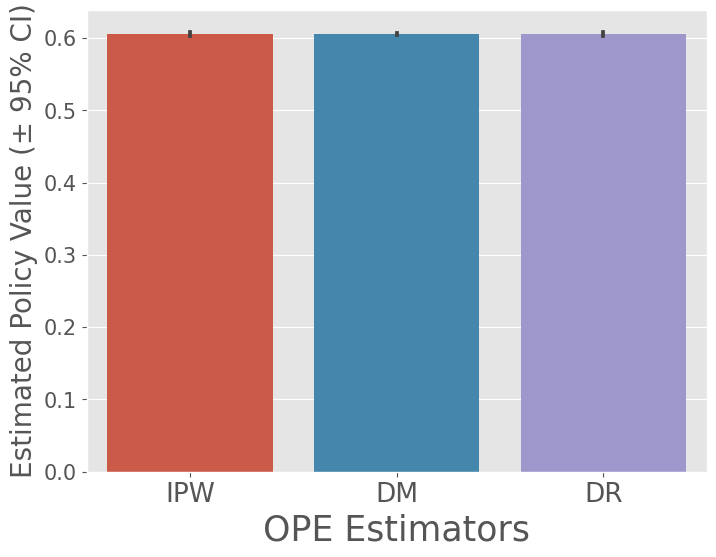

In [37]:
# ベースラインであるランダム推薦の性能
estimated_policy_value_c, estimated_interval_c = ope.summarize_off_policy_estimates(
    action_dist=action_dist_random,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model
)
print(estimated_interval_c,"\n")

ope.visualize_off_policy_estimates(
    action_dist=action_dist_random,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    n_bootstrap_samples=1000,
    random_state=12345
)

## (4) Evaluation of OPE estimators
### (4-1) Approximate the Ground-truth Policy Value

$$
J(\pi_e) \approx \frac{1}{|\mathcal{D}_{te}|} \sum_{i=1}^{|\mathcal{D}_{te}|} \mathbb{E}_{a \sim \pi_e(a|x_i)} [q(x_i,a)], \; \, where \; \, q(x,a) := \mathbb{E}_{r \sim p(r|x,a)} [r]
$$

In [38]:
policy_names = [
    "IPW Learner with Logistic Regression", 
    "IPW Learner with Random Forest", 
    "Uniform Random"
]
for name, action_dist in zip(policy_names, [action_dist_ipw_lr, action_dist_ipw_rf, action_dist_random]):
    true_policy_value = dataset.calc_ground_truth_policy_value(
        expected_reward=bandit_feedback_test["expected_reward"],
        action_dist=action_dist
    )
    print(f'policy value of {name}: {true_policy_value}')

policy value of IPW Learner with Logistic Regression: 0.7794237175980125
policy value of IPW Learner with Random Forest: 0.7161955411283469
policy value of Uniform Random: 0.606060477451349


### (4-2) Evaluation of OPE

$$
\textit{relative-ee} (\hat{J}; \mathcal{D}_b) := \left| \frac{J(\pi_e)-\hat{J} (\pi_e; \mathcal{D}_b)}{J(\pi_e)} \right|$$(relative estimation error; relative-ee)


$$
\textit{SE} (\hat{J}; \mathcal{D}_b) := \left(J(\pi_e) - \hat{J} (\pi_e; \mathcal{D}_b) \right)^2
$$ (squared error; SE)

In [42]:
# evaluate IPWLearner with Logistic Regression
relative_ee_for_ipw_lr = ope.summarize_estimators_comparison(
    ground_truth_policy_value=dataset.calc_ground_truth_policy_value(
        expected_reward=bandit_feedback_test["expected_reward"],
        action_dist=action_dist_ipw_lr
    ),
    action_dist=action_dist_ipw_lr,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    metric="relative-ee", #"relative-ee" (relative estimation error) or "se" (squared error)
)

relative_ee_for_ipw_lr

,relative-ee
ipw,0.007283
dm,0.177066
dr,0.001293


In [43]:
# evaluate IPWLearner with Random Forest
relative_ee_for_ipw_rf = ope.summarize_estimators_comparison(
    ground_truth_policy_value=dataset.calc_ground_truth_policy_value(
        expected_reward=bandit_feedback_test["expected_reward"],
        action_dist=action_dist_ipw_rf
    ),
    action_dist=action_dist_ipw_rf,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    metric="relative-ee", #"relative-ee" (relative estimation error) or "se" (squared error)
)

relative_ee_for_ipw_rf

,relative-ee
ipw,0.006277
dm,0.124521
dr,0.000807


In [44]:
# evaluate Uniform Random
relative_ee_for_random = ope.summarize_estimators_comparison(
    ground_truth_policy_value=dataset.calc_ground_truth_policy_value(
        expected_reward=bandit_feedback_test["expected_reward"],
        action_dist=action_dist_random
    ),
    action_dist=action_dist_random,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    metric="relative-ee", #"relative-ee" (relative estimation error) or "se" (squared error)
)

relative_ee_for_random

,relative-ee
ipw,0.001469
dm,0.001274
dr,0.001286
